In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()


(ipykernel_launcher.py:1451): Gtk-CRITICAL **: 15:46:37.235: gtk_window_resize: assertion 'height > 0' failed
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown
15:46:38: Debug: ScreenToClient cannot work when toplevel window is not shown


In [ ]:
import subprocess
dataset_id = 'ds000171'
subject_id = 'control01'

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)

# Download one subject's data from each dataset
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", op.join('sub-{}'.format(subject_id), '*'),# We are asking to get all files within the subject_dir/anat folder by using the wildcard *
               ], check=True)

In [7]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [4]:
print(bids_root)

/home/jovyan/Data/dataset/ds000171


## 1.1.1 fMRI Voxel Standardization

### Old

In [ ]:
mkdir_no_exist(op.join(preproc_root, "sub-{}".format(subject_id), "func"))

# Run the standarization for each task run
for r in range(1, 4):
    # Compute the mean of the fMRI data
    subprocess.run(["bet", op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, r)),
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}.nii.gz".format(subject_id, r)), '-m'
    ], check=True)

    subprocess.run(["fslmaths", op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, r)),
                    '-mas', op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_mask.nii.gz".format(subject_id, r)),
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_masked.nii.gz".format(subject_id, r))
    ], check=True)
    
    subprocess.run(["fslmaths", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_masked.nii.gz".format(subject_id, r)), "-mean", 
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_mean.nii.gz".format(subject_id, r))        
        
    ], check=True)

    # Computer the std of the fMRI data     
    subprocess.run(["fslmaths", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_masked.nii.gz".format(subject_id, r)), "-std",
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_std.nii.gz".format(subject_id, r))        
        
    ], check=True)

    # # Correct the zero values in the std
    # subprocess.run(["fslmaths", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_std.nii.gz".format(subject_id, r)),
    #                 "-add", "0.001",
    #                 op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_stdfix.nii.gz".format(subject_id, r))
        
    # ], check=True)

    # Standardize data (X - mean / std)                  
    subprocess.run(["fslmaths", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_masked.nii.gz".format(subject_id, r)), "-sub",
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_mean.nii.gz".format(subject_id, r)), "-div",
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_std.nii.gz".format(subject_id, r)),
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_standardized.nii.gz".format(subject_id, r))
        
    ], check=True)

### New: through fslmaths inm (intenisty normalization (through 3d mean))

In [5]:
mkdir_no_exist(op.join(preproc_root, "sub-{}".format(subject_id), "func"))

for r in range(1,4):
    # Standardize so that the mean becomes 100
    subprocess.run(["fslmaths", op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, r)),
                    "-inm", "100", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_inm.nii.gz".format(subject_id, r)),
    ], check=True)

print("done")

done


In [7]:
fmri_files = []

for r in range(1, 4):
    fmri_files.append(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_inm.nii.gz".format(subject_id, r)))

concat_img = nilearn.image.concat_imgs(fmri_files)
concat_img.to_filename(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_concat.nii.gz".format(subject_id)))

In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_inm.nii.gz".format(subject_id, 2)))
# fsleyesDisplay.load(op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, 1)))


(ipykernel_launcher.py:1451): Gdk-WARNING **: 15:59:59.892: gdkdrawable-x11.c:952 drawable is not a pixmap or window


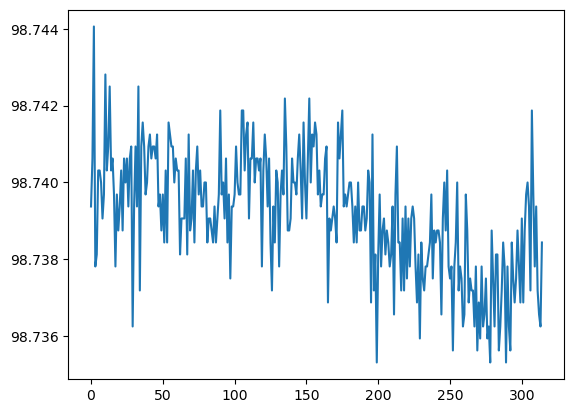

In [11]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_concat.nii.gz".format(subject_id))).get_fdata().mean(axis=(0,1,2)))


## 1.1.2 Skull Stripping, Motion Correction, and Smoothing

In [13]:
subprocess.run(["bet", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_concat.nii.gz".format(subject_id)),
                op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)), "-m", "-F",
    
], check=True)

CompletedProcess(args=['bet', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concat.nii.gz', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_stripped.nii.gz', '-m', '-F'], returncode=0)

#### TODO: Perform manual correction on skull stripping

In [14]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)))
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped_mask.nii.gz".format(subject_id)))



(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:04:14.406: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:04:14.406: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:04:14.406: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:04:14.406: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:04:14.406: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:04:14.406: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:04:14.406: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:04:14.406: file ../gio/gfileinfo.

In [17]:
mcflirt(infile=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)), o=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id)), plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_moco.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}


(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:09:44.599: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:09:44.599: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:09:44.599: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:09:44.599: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:11:44.652: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:11:44.652: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:11:44.652: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:11:44.652: file ../gio/gfileinfo.

In [19]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id)))


(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:13:44.703: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:13:44.703: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:13:44.703: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:13:44.703: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:15:44.759: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:15:44.759: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:15:44.759: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:15:44.759: file ../gio/gfileinfo.

In [22]:
# nilearn.image.smooth_img(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id)),6)
subprocess.run(['fslmaths',op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id)), '-s', str(4/2.3548), '{}_smoothed-6mm'.format(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id)))])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_moco.nii.gz', '-s', '1.6986580601324954', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_moco.nii.gz_smoothed-6mm'], returncode=0)


(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:23:44.993: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:23:44.993: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:23:44.993: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:23:44.993: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached


In [24]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('{}_smoothed-6mm'.format(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco".format(subject_id))))


(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:25:45.049: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:25:45.049: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:25:45.049: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:25:45.049: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:27:45.100: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:27:45.100: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:27:45.100: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:27:45.100: file ../gio/gfileinfo.

In [40]:
file = op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco_smoothed-6mm.nii.gz".format(subject_id))
img = nib.load(file)
a = np.array(img)
print(a)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (80, 80, 50, 315)
affine:
[[-2.89823341e+00  0.00000000e+00  1.04698524e-01  1.18931046e+02]
 [-6.50556833e-02  2.22152901e+00 -1.92718816e+00 -7.74534302e+01]
 [ 7.75302127e-02  1.86408401e+00  2.29673338e+00 -1.40277512e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  80  80  50 315   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   2.9  2.9  3.   3.   1.   1.   1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min      


(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:53:45.822: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:53:45.822: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:53:45.822: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:53:45.822: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:54:08.815: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:54:08.815: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:54:08.816: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1451): GLib-GIO-CRITICAL **: 16:54:08.816: file ../gio/gfileinfo.

In [ ]:

t_r=3.0
n_scans=